# Imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from itertools import product

In [2]:
%matplotlib inline

# Config

In [3]:
DATA_FILE_PATHS = '/workspace/rahnemacollege/Project/Git/demand-prediction/data'
SHAPE_FILE_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/map_data/taxi_zones/taxi_zones.shp'
LR_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/lr_result.parquet'
XGB_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/XGB_result.parquet'

start_date_test = '2023-04-01'
end_date_test = '2023-05-01'

# Load Data files

In [4]:
def load_data(file_paths):
    df = pd.read_parquet(file_paths).reset_index()
    df = df.rename(columns={'real demand': 'count',
                   'predicted demand': 'pred_count'})
    return df

In [5]:
lr_rides_df = load_data(LR_PATH)
print(lr_rides_df.shape)
lr_rides_df.head()

(8646, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,-0.0
1,2023-04-01,132,1,5,6059.0,5191.0,5678.0,5429.0
2,2023-04-01,165,1,5,3.0,3.0,2.0,4.0
3,2023-04-01,3,1,5,6.0,1.0,1.0,1.0
4,2023-04-01,147,1,5,2.0,1.0,4.0,2.0


In [6]:
xgb_rides_df = load_data(XGB_PATH)
print(xgb_rides_df.shape)
xgb_rides_df.head()

(8646, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,3.0
1,2023-04-01,132,1,5,6059.0,5191.0,5678.0,5374.0
2,2023-04-01,165,1,5,3.0,3.0,2.0,3.0
3,2023-04-01,3,1,5,6.0,1.0,1.0,3.0
4,2023-04-01,147,1,5,2.0,1.0,4.0,3.0


### Improved Data Bound Within Range: 2023-04-01 to 2023-04-30

For Model Evaluation

In [7]:
def df_time_bound(df):
    df['date'] = pd.to_datetime(df['date'])
    filtered_rides_df = df[(df['date'] >= start_date_test) & (
        df['date'] < end_date_test)]
    # Sort the DataFrame based on the 'tpep_pickup_datetime' column in ascending order
    filtered_rides_df = filtered_rides_df.sort_values(by='date')
    filtered_rides_df = filtered_rides_df.reset_index(drop=True)
    return filtered_rides_df

In [8]:
lr_rides_df = df_time_bound(lr_rides_df)
print(lr_rides_df.shape)
lr_rides_df.head()

(7860, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,-0.0
1,2023-04-01,180,1,5,4.0,3.0,1.0,4.0
2,2023-04-01,164,1,5,2735.0,2627.0,2896.0,2682.0
3,2023-04-01,144,1,5,1028.0,1486.0,1443.0,1413.0
4,2023-04-01,140,1,5,2415.0,1644.0,1653.0,1820.0


In [9]:
xgb_rides_df = df_time_bound(xgb_rides_df)
print(xgb_rides_df.shape)
xgb_rides_df.head()

(7860, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,3.0
1,2023-04-01,180,1,5,4.0,3.0,1.0,3.0
2,2023-04-01,164,1,5,2735.0,2627.0,2896.0,2717.0
3,2023-04-01,144,1,5,1028.0,1486.0,1443.0,1379.0
4,2023-04-01,140,1,5,2415.0,1644.0,1653.0,1818.0


# Report by MAPE Metric

### Define MAPE Metric Function

In [10]:
# Define the MAPE calculation function
def calculate_mape(actual, predicted):
    return (abs((actual - predicted) / actual)).mean() * 100


# Calculate MAPE
mape = calculate_mape(
    xgb_rides_df['count'], xgb_rides_df['pred_count'])
print("MAPE: {:.2f}%".format(mape))

MAPE: 79.76%


### Calculate MAPE per LocationID

In [11]:
def calculate_mape_locationID(df, Location_Col, LocationID):
    selected_df = df[df[Location_Col] == LocationID]
    actual = selected_df['count']
    predicted = selected_df['pred_count']
    mape = calculate_mape(actual, predicted)
    return mape

In [12]:
locationID_mape = 2
mape_LocationID_output = calculate_mape_locationID(
    xgb_rides_df, 'PULocationID', locationID_mape)
print("MAPE for LocationID {}: {:.2f}%".format(
    locationID_mape, mape_LocationID_output))

MAPE for LocationID 2: 298.33%


### Calculate Average MAPE per all LocationIDs

In [13]:
PULocationIDs = xgb_rides_df['PULocationID'].unique()
PULocationIDs.sort()
mape_all = []
for locationID in PULocationIDs:
    mape_location = calculate_mape_locationID(
        xgb_rides_df, 'PULocationID', locationID)
    mape_all.append({'LocationID': locationID, 'MAPE': mape_location})


PULocationIDs_MAPE = pd.DataFrame(mape_all)
print(PULocationIDs_MAPE.shape)
print(PULocationIDs_MAPE.head())


AvgMAPE = sum(PULocationIDs_MAPE['MAPE'].values)/len(PULocationIDs)
print("Average MAPE per LocationIDs: {:.2f}%".format(mape))

(262, 2)
   LocationID        MAPE
0           1   32.349595
1           2  298.333333
2           3  109.444444
3           4   21.665669
4           5  136.166667
Average MAPE per LocationIDs: 79.76%


## Visualization

### MAPE Metric on Map based on selected date

Zones (Borough): **EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn**

Date Range: **2023-04-01_2023-04-30**

Lower is better based on MAPE Metric

In [14]:
zones = ['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn']

In [15]:
# This function shows MAPE metric on map based on selected date of month

def visualize_mape_zone_date(zone, date, df):
    shape = gpd.read_file(SHAPE_FILE_PATH)
    counts_PU = df.rename(columns={'PULocationID': 'LocationID'})
    counts_PU = counts_PU[counts_PU['date'] == date]
    merged_gdf = shape.merge(counts_PU, on='LocationID', how='left')
    merged_gdf = merged_gdf.dropna()
    merged_gdf['MAPE'] = np.where(merged_gdf['count'] != 0, (abs(
        (merged_gdf['count'] - merged_gdf['pred_count']) / merged_gdf['count'])) * 100, 1)
    merged_gdf_selected = merged_gdf[merged_gdf['borough'] == zone]

    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Plot the map with 'MAPE' column
    merged_gdf_selected.plot(
        column='MAPE', cmap='Oranges_r', legend=True, ax=ax)
    ax.set_title(
        'Prediction based on MAPE for {} and selected date: {}'.format(zone, date))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate 'MAPE' values on the map
    for idx, row in merged_gdf_selected.iterrows():
        loc_mape = "{}".format(row['LocationID'])
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, str(loc_mape), fontsize=8,
                ha='center', va='center', color='black')

    plt.show()

In [16]:
# for i in zones:
#    visualize_mape_zone_date(i, '2023-04-01', xgb_rides_df)

### MAPE Metric on Map based on whole test data

Zones (Borough): **EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn**

Lower is better

In [17]:
# This function shows MAPE metric on map based on whole test data
def visualize_mape_zone(zone, df):
    shape = gpd.read_file(SHAPE_FILE_PATH)
    counts_PU = df.rename(
        columns={'PULocationID': 'LocationID'})
    merged_gdf = shape.merge(counts_PU, on='LocationID', how='left')
    merged_gdf = merged_gdf.dropna()
    merged_gdf_selected = merged_gdf[merged_gdf['borough'] == zone]

    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Plot the map with 'count' column
    # Reverse the colormap by setting vmin and vmax to reverse the values
    merged_gdf_selected.plot(
        column='MAPE', cmap='Oranges_r', legend=True, ax=ax)
    ax.set_title('Prediction based on MAPE for {}'.format(zone))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate 'MAPE' values on the map
    for idx, row in merged_gdf_selected.iterrows():
        location_id = "{}".format(row['LocationID'])
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, str(location_id), fontsize=8,
                ha='center', va='center', color='black')

    plt.show()

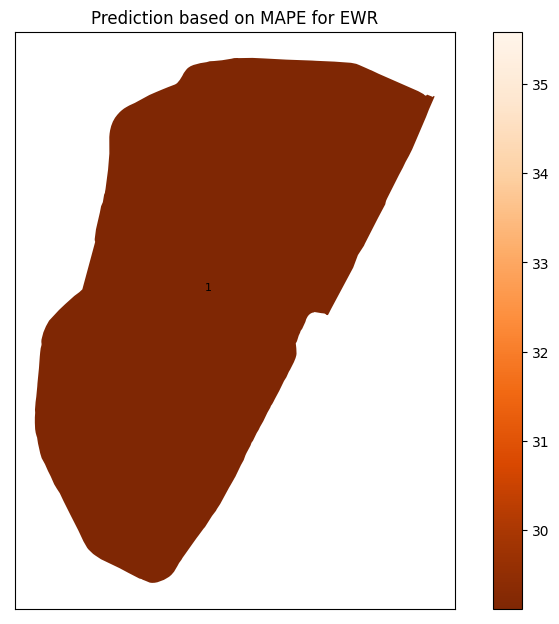

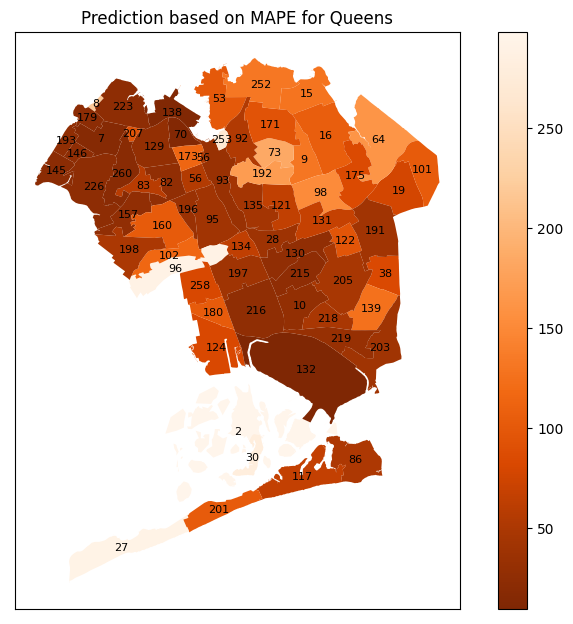

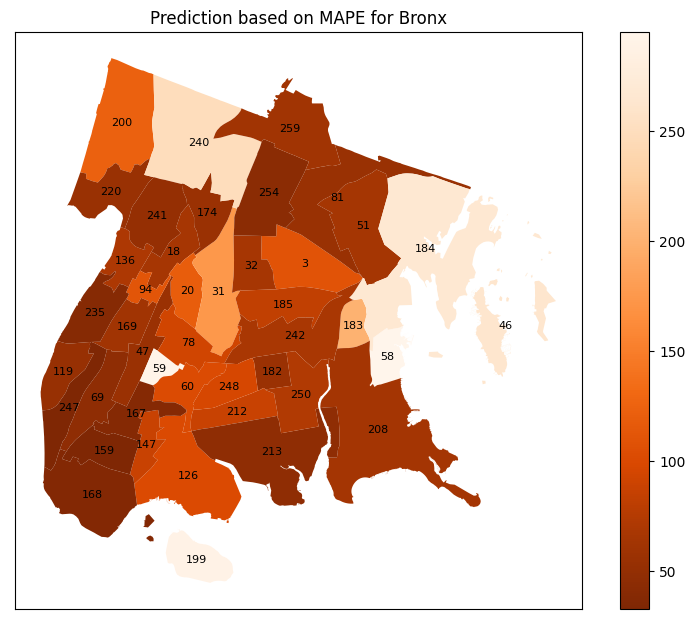

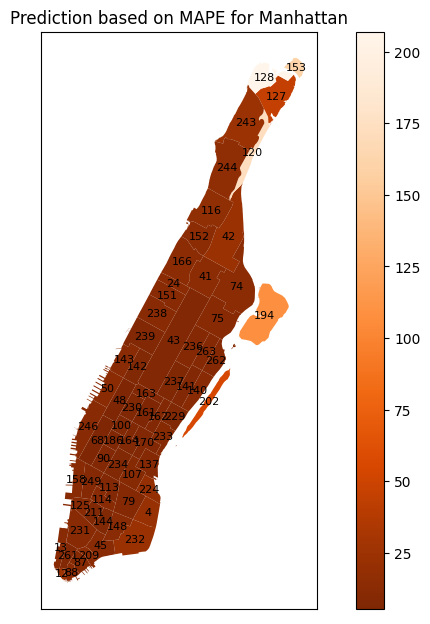

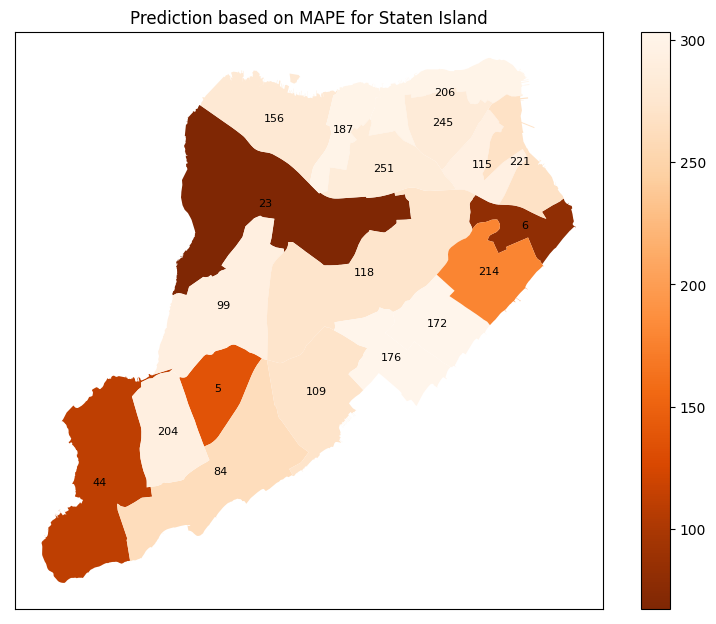

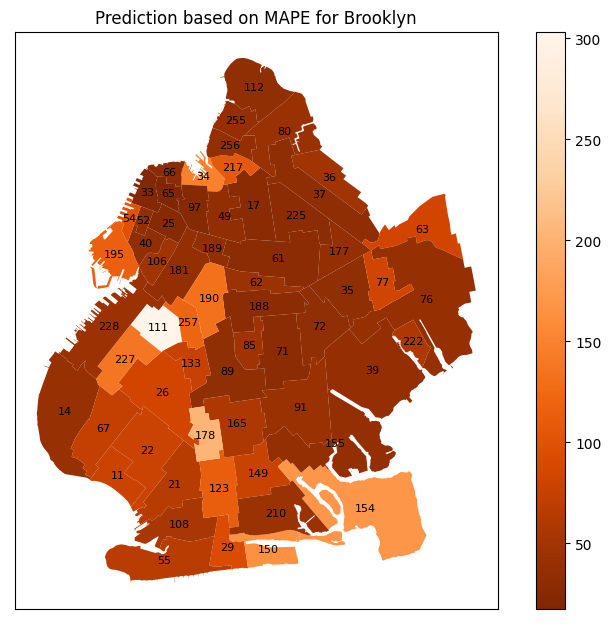

In [18]:
for i in zones:
    visualize_mape_zone(i, PULocationIDs_MAPE)

### Predicted demand on whole test data

Zones (Borough): **EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn**

In [19]:
def visualize_demand_zone(zone, df, col_show):
    shape = gpd.read_file(SHAPE_FILE_PATH)
    counts_PU = df.rename(columns={'PULocationID': 'LocationID'})
    counts_PU = counts_PU.groupby('LocationID')[['last_day_demand', 'count', 'pred_count']].sum(
    ).sort_values(col_show, ascending=False).reset_index()
    merged_gdf = shape.merge(counts_PU, on='LocationID', how='left')
    merged_gdf = merged_gdf.dropna()
    merged_gdf_selected = merged_gdf[merged_gdf['borough'] == zone]

    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Plot the map with 'MAPE' column
    merged_gdf_selected.plot(
        column='count', cmap='Oranges', legend=True, ax=ax)
    ax.set_title('{} of demands Zone: {}'.format(col_show, zone))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate 'MAPE' values on the map
    for idx, row in merged_gdf_selected.iterrows():
        loc_mape = "{}".format(row['LocationID'])
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, str(loc_mape), fontsize=8,
                ha='center', va='center', color='black')

    plt.show()

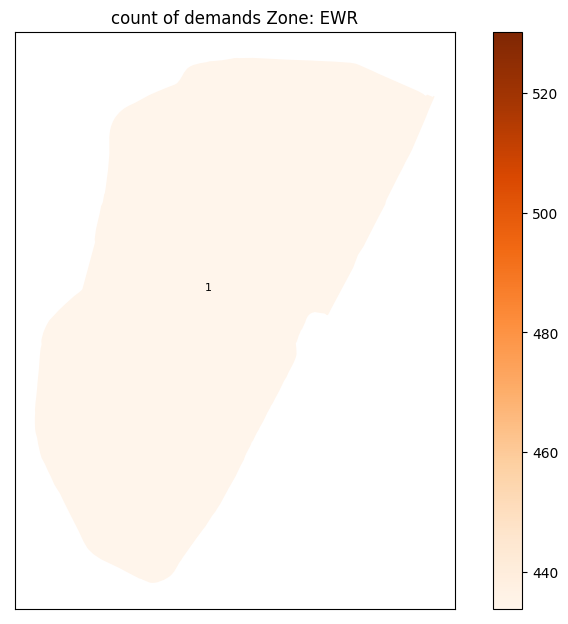

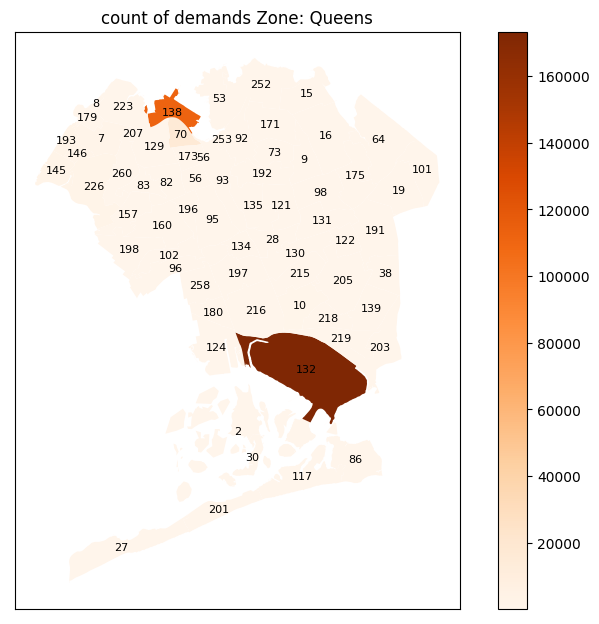

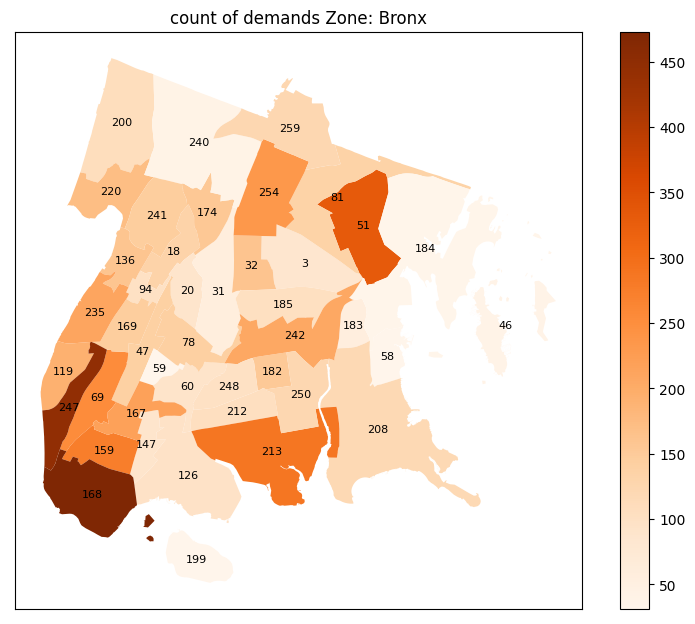

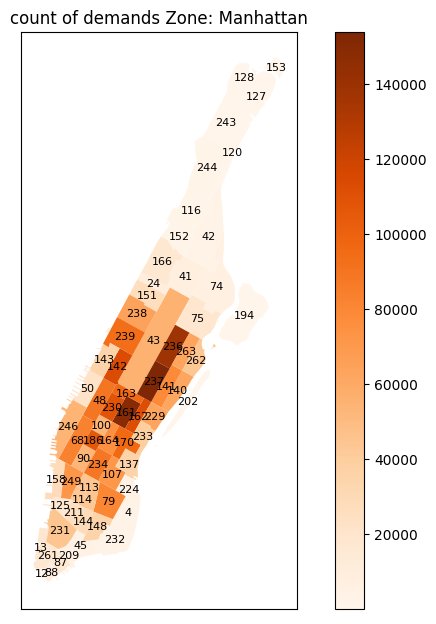

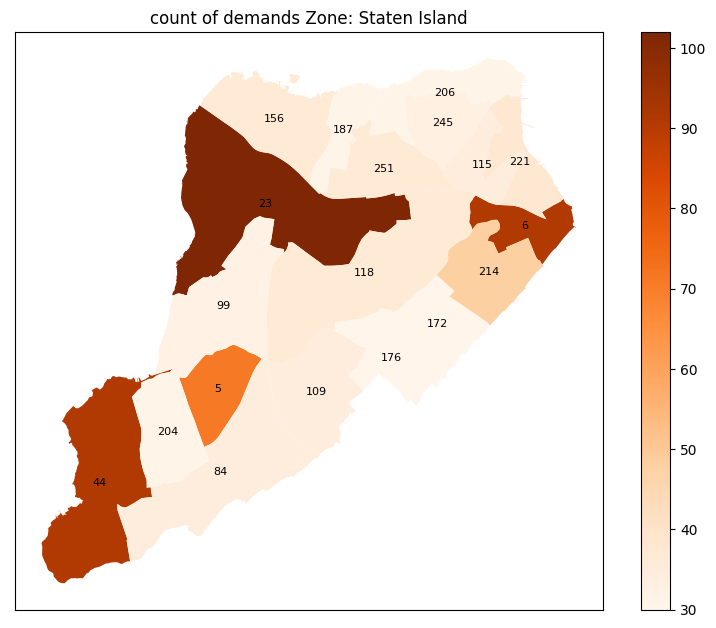

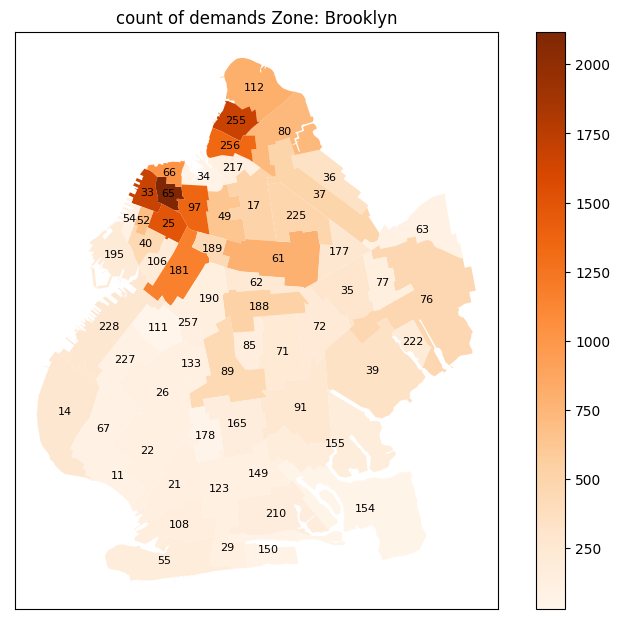

In [20]:
for i in zones:
    visualize_demand_zone(i, xgb_rides_df, 'count')

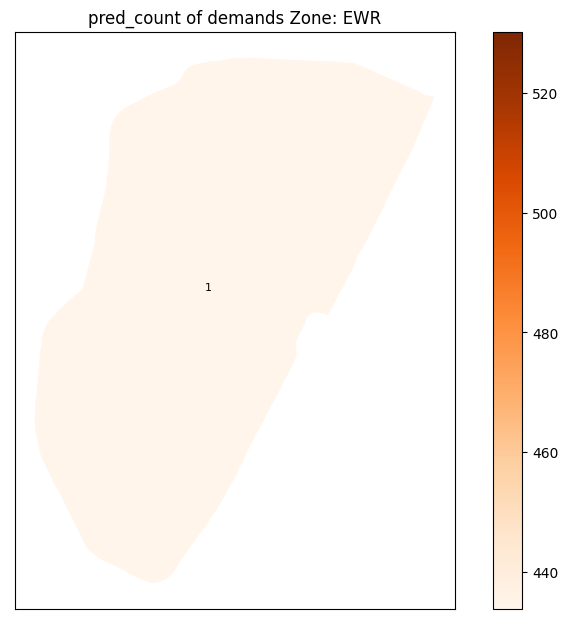

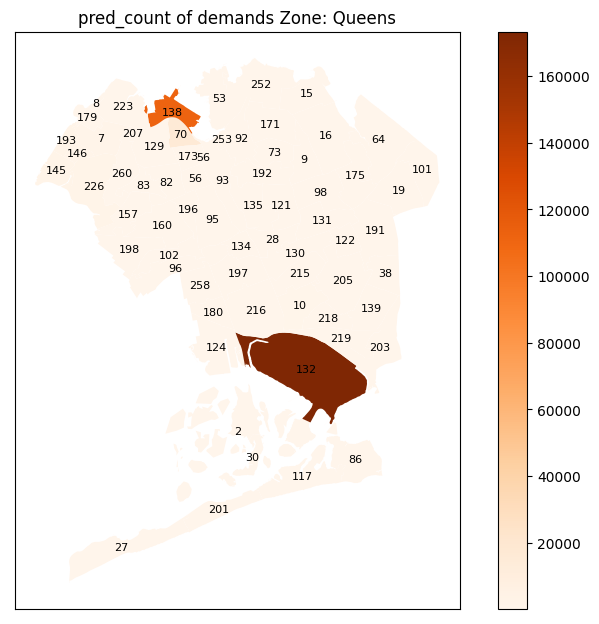

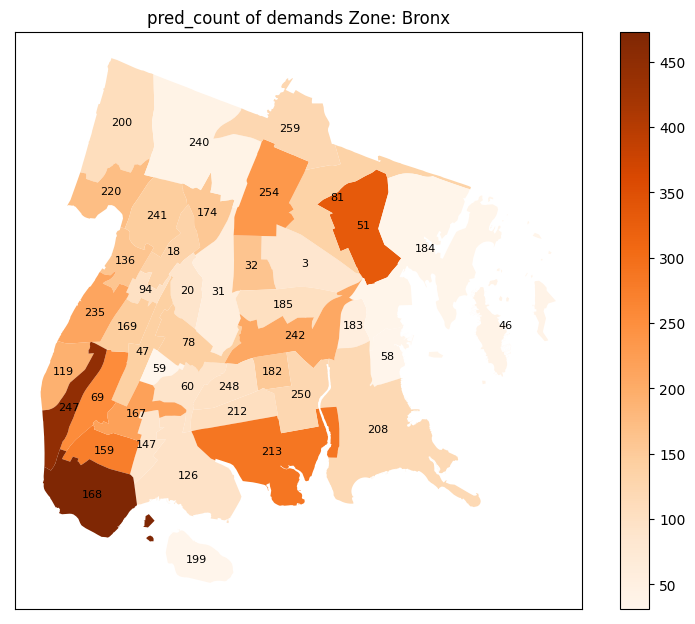

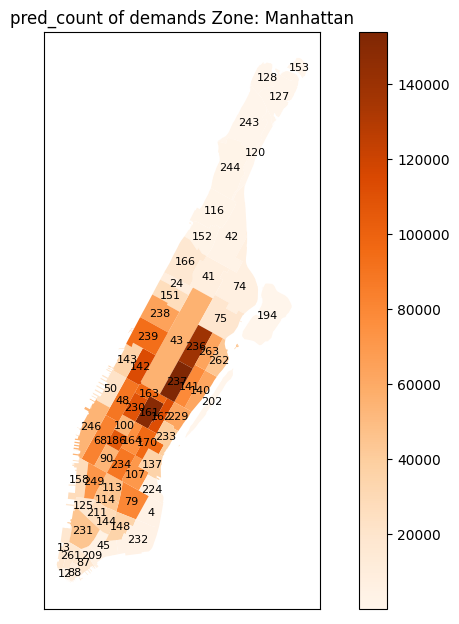

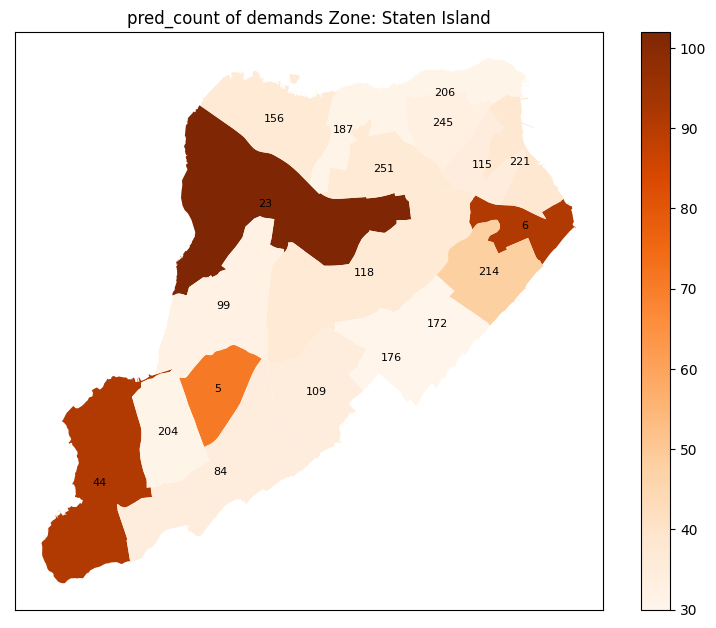

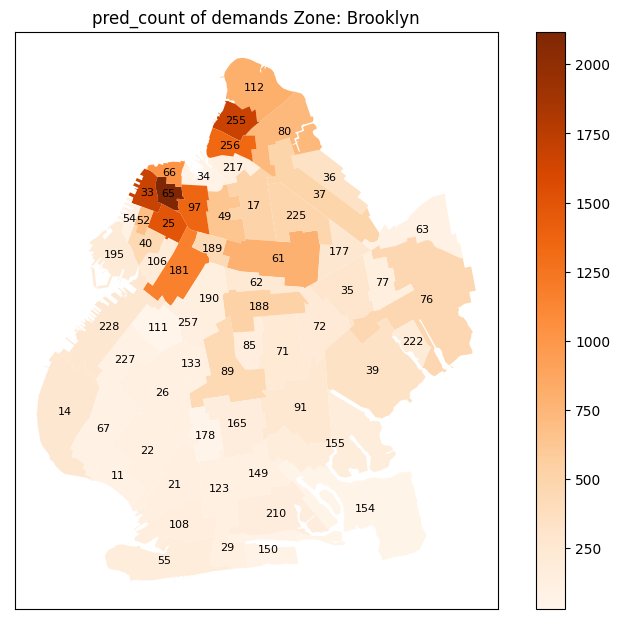

In [21]:
for i in zones:
    visualize_demand_zone(i, xgb_rides_df, 'pred_count')

## Cumulative Histogram

### Compare Models prediction vs. Last day count base on MAPE metric

In [22]:
def compare_models(model1, model2, lower_bound=0, upper_bound=262):
    xgb = model1.groupby('PULocationID')[['last_day_demand', 'count', 'pred_count']].sum(
    ).sort_values('count', ascending=False).reset_index()
    xgb['MAPE'] = ((abs(xgb['count'] - xgb['pred_count']) / xgb['count'])*100)
    xgb['MAPE_lastday'] = (
        (abs(xgb['count'] - xgb['last_day_demand']) / xgb['count'])*100)

    lr = model2.groupby('PULocationID')[['last_day_demand', 'count', 'pred_count']].sum(
    ).sort_values('count', ascending=False).reset_index()
    lr['MAPE'] = ((abs(lr['count'] - lr['pred_count']) / lr['count'])*100)
    lr['MAPE_lastday'] = (
        (abs(lr['count'] - lr['last_day_demand']) / lr['count'])*100)

    selected_df = xgb.iloc[lower_bound:upper_bound]
    selected_df1 = lr.iloc[lower_bound:upper_bound]

    plt.figure(figsize=(20, 5))
    plt.title('Count demand of LocationIDs Compare Models vs. Last day count')

    plt.plot(selected_df['MAPE'], label="MAPE Of XGB")
    plt.plot(selected_df1['MAPE'], label="MAPE Of Linear Regression")
    plt.plot(selected_df['MAPE_lastday'], label="MAPE Of LastDay")

    plt.xticks(selected_df.index, selected_df['PULocationID'], rotation=90)

    plt.legend()
    plt.xlabel('LocationID')
    plt.ylabel('Percetage MAPE%')

    plt.show()

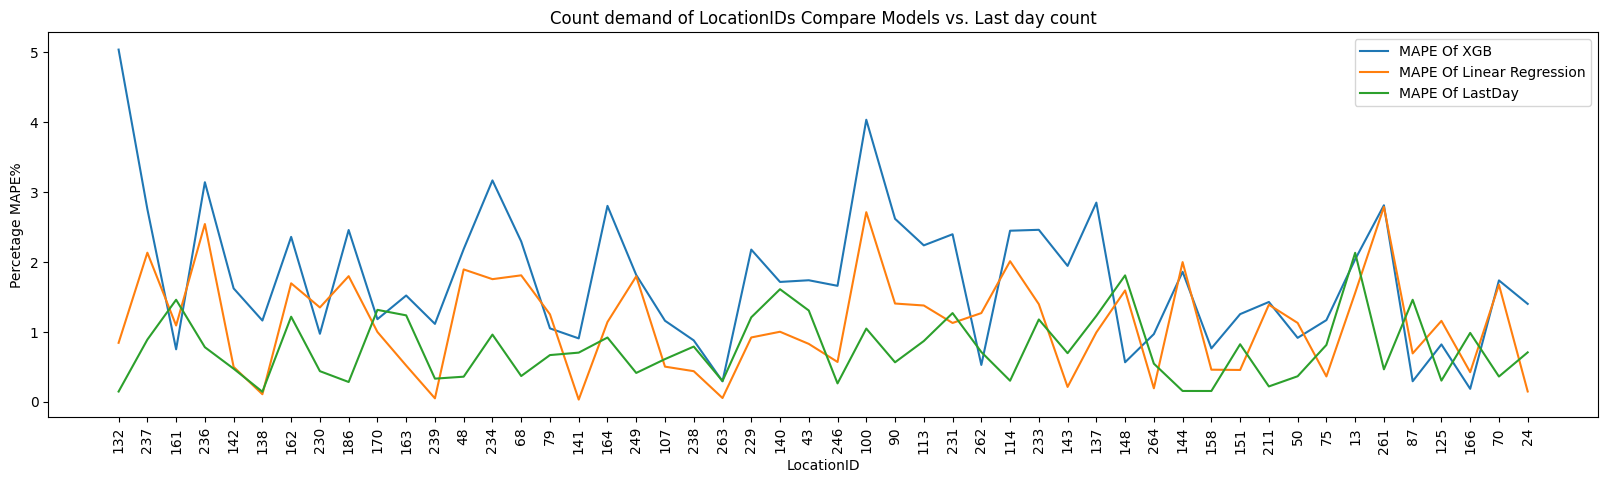

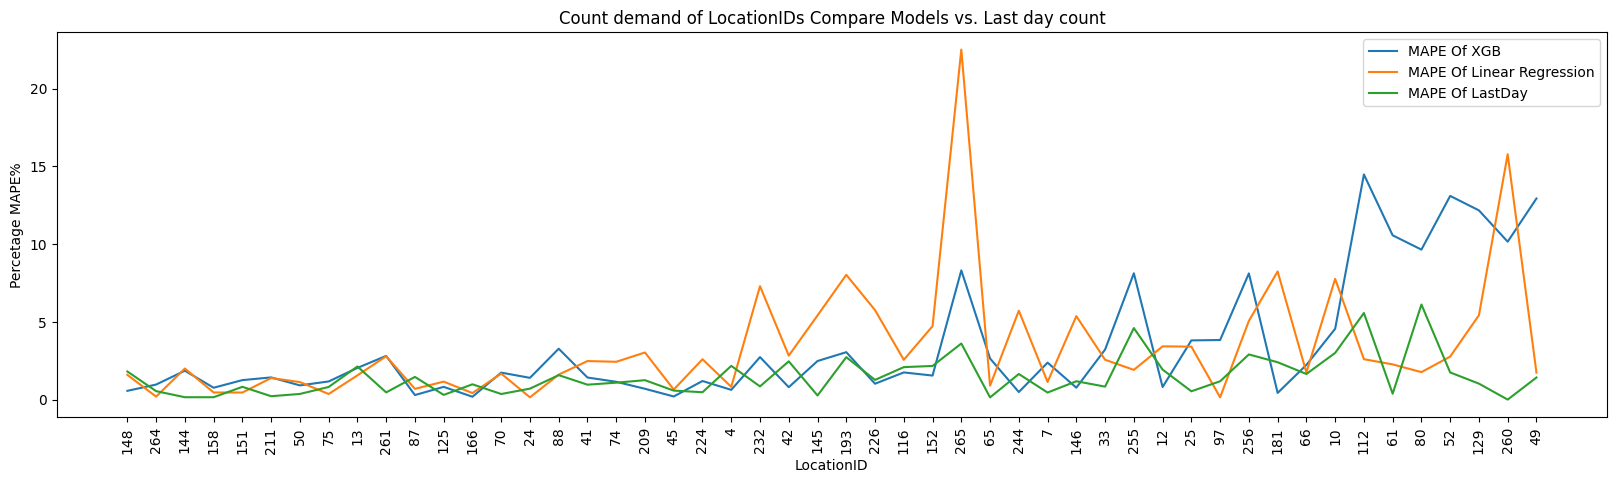

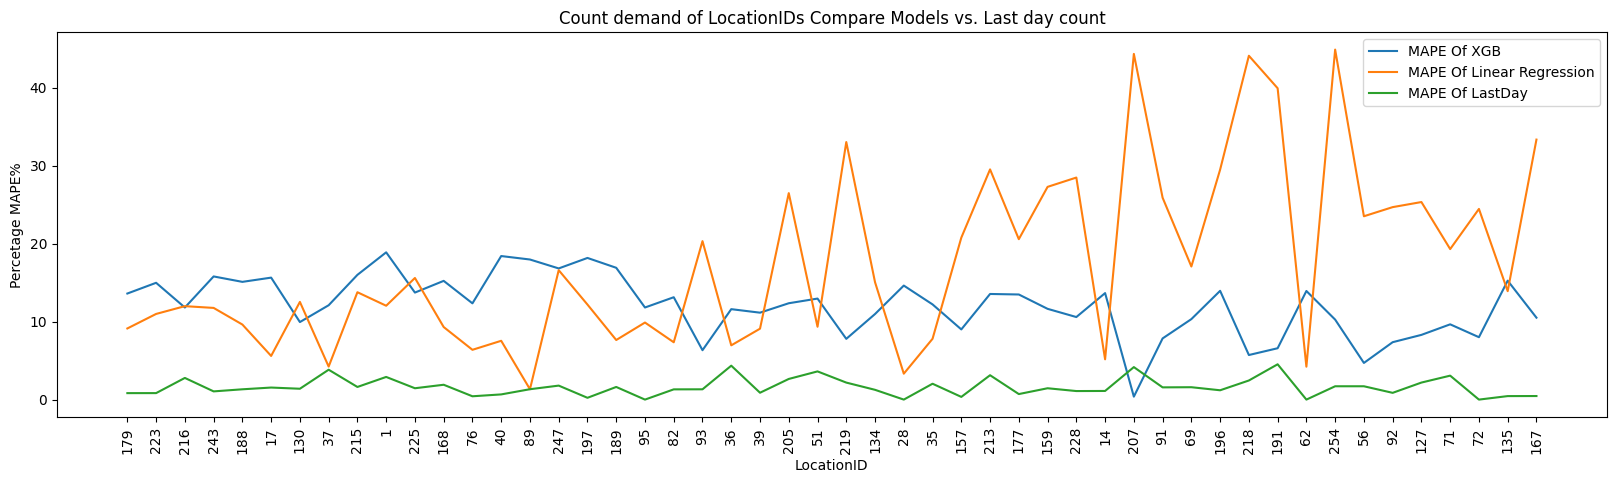

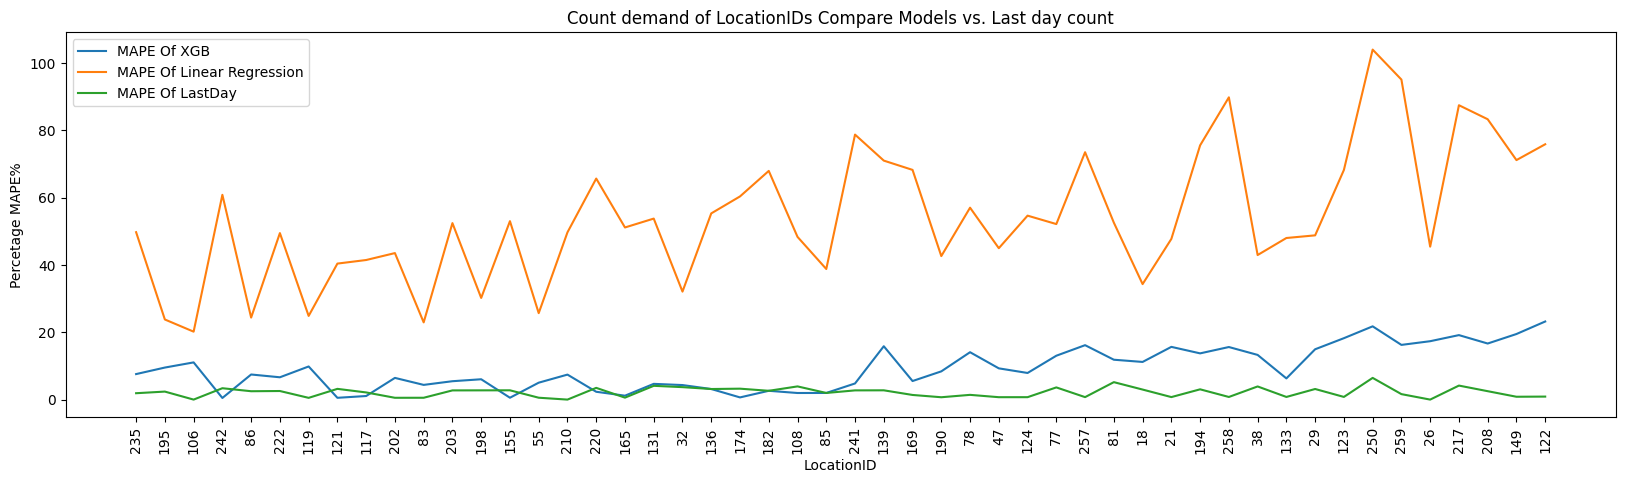

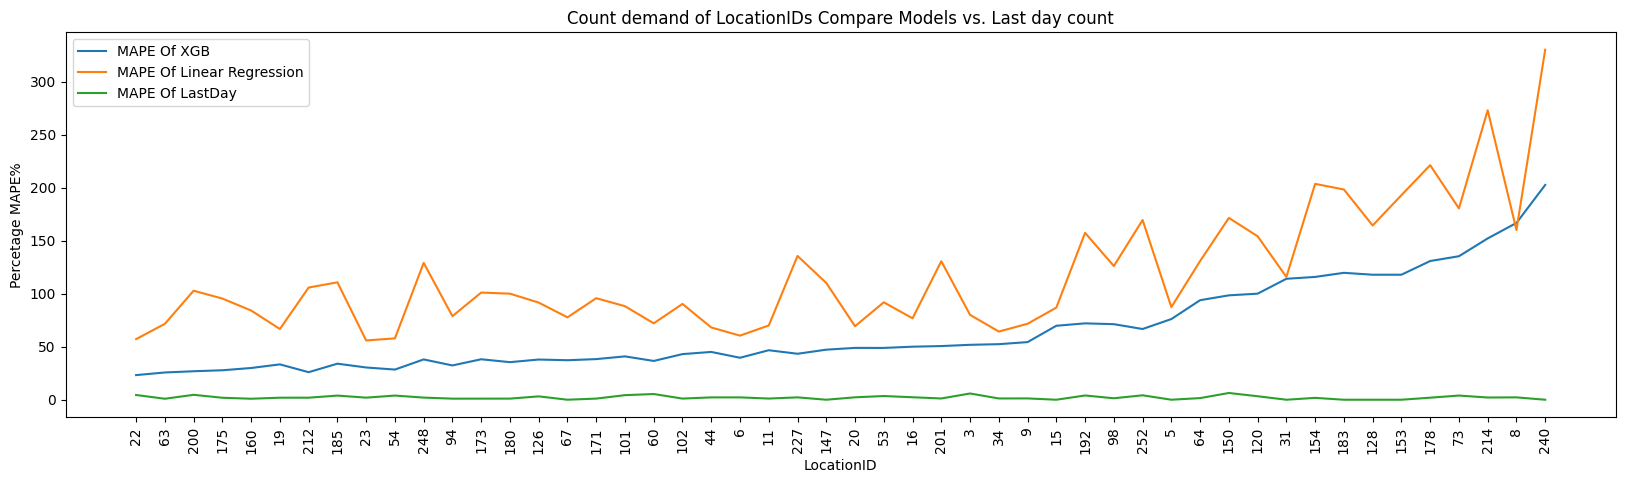

In [23]:
for i in range(0, 250, 50):
    if i == 0:
        compare_models(xgb_rides_df, lr_rides_df, i, i+50)
    else:
        compare_models(xgb_rides_df, lr_rides_df, i-15, i+35)

### Compare Models predicion vs. Last day count based on actual count

In [24]:
def compare_model_scatter(model1, model2, lower_bound=0, upper_bound=262):
    xgb = model1.groupby('PULocationID')[['last_day_demand', 'count', 'pred_count']].sum(
    ).sort_values('count', ascending=False).reset_index()

    lr = model2.groupby('PULocationID')[['last_day_demand', 'count', 'pred_count']].sum(
    ).sort_values('count', ascending=False).reset_index()

    selected_df = xgb.iloc[lower_bound:upper_bound]
    selected_df1 = lr.iloc[lower_bound:upper_bound]

    plt.figure(figsize=(15, 5))
    plt.scatter(selected_df.index,
                selected_df['count'], label="Actual", color='red', s=15)
    plt.plot(selected_df.index, selected_df['pred_count'], label="XGB")
    plt.plot(selected_df.index, selected_df1['pred_count'], label="LR")
    plt.plot(selected_df.index,
             selected_df1['last_day_demand'], label="Last day")

    plt.xticks(selected_df.index, selected_df['PULocationID'], rotation=90)

    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Counts')
    plt.title('Demand count Compare XGBoost Model vs Last day')

    plt.show()

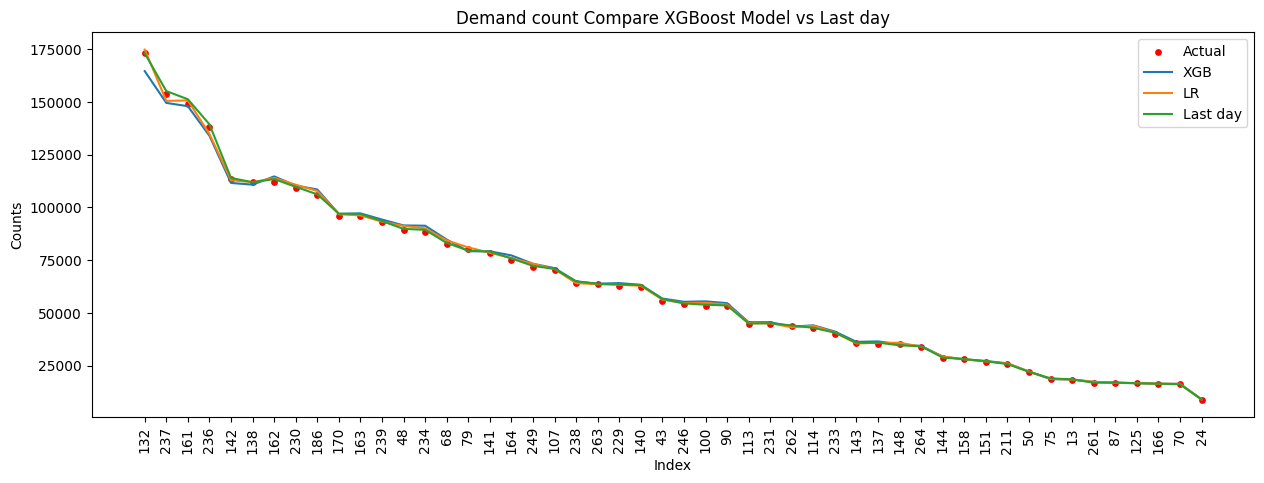

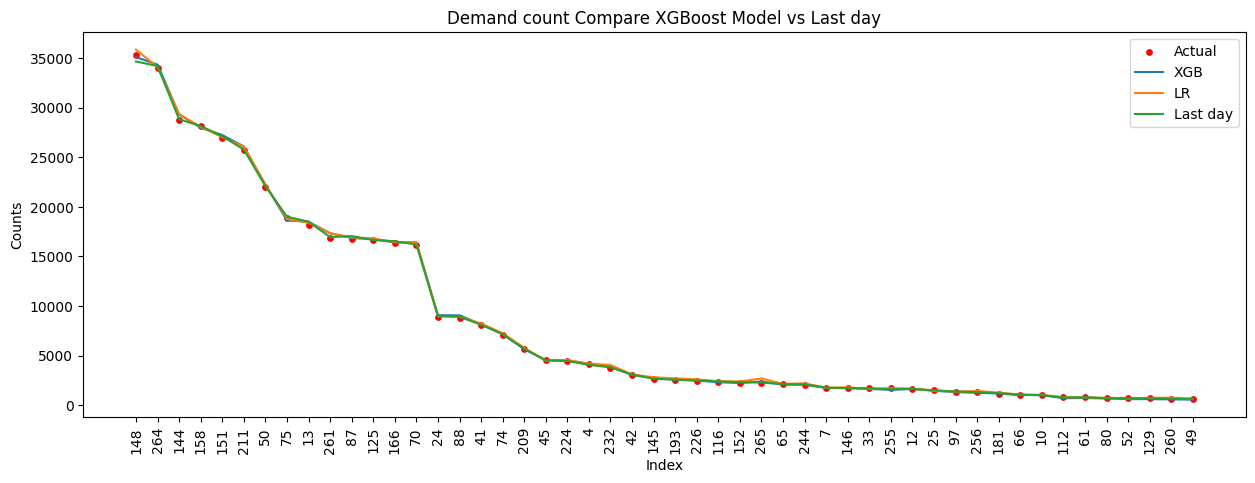

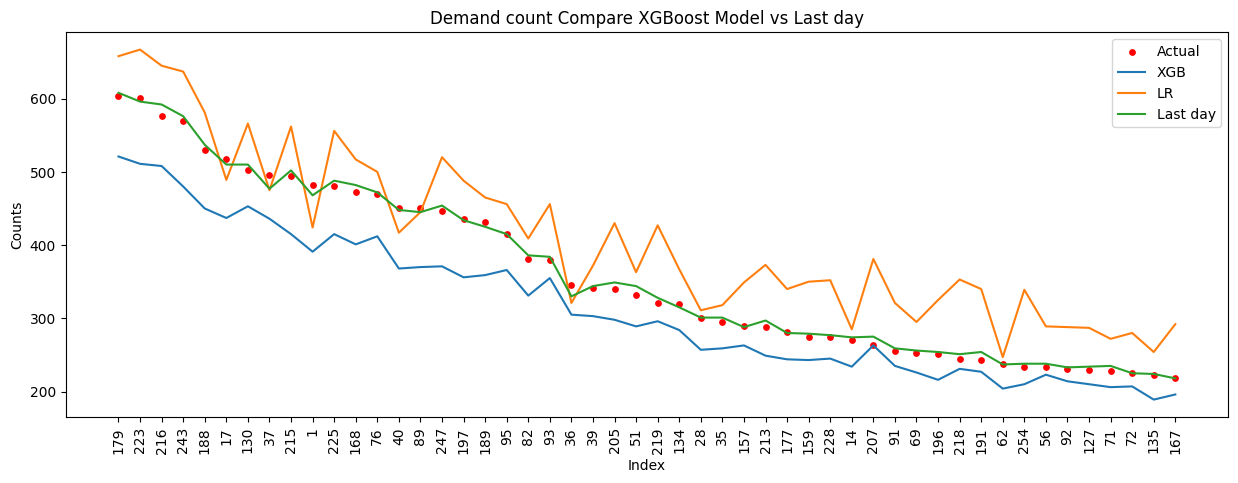

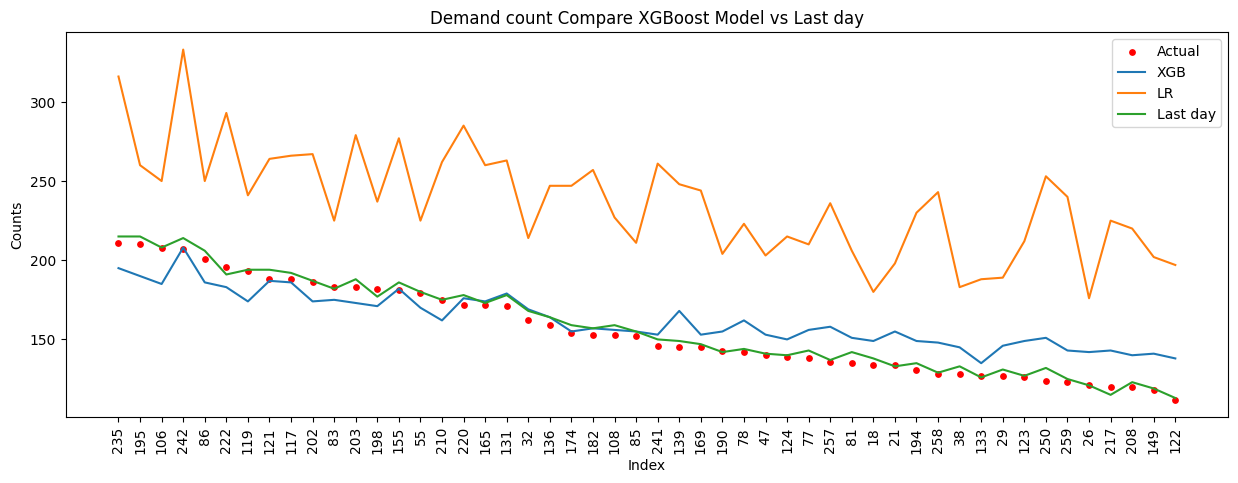

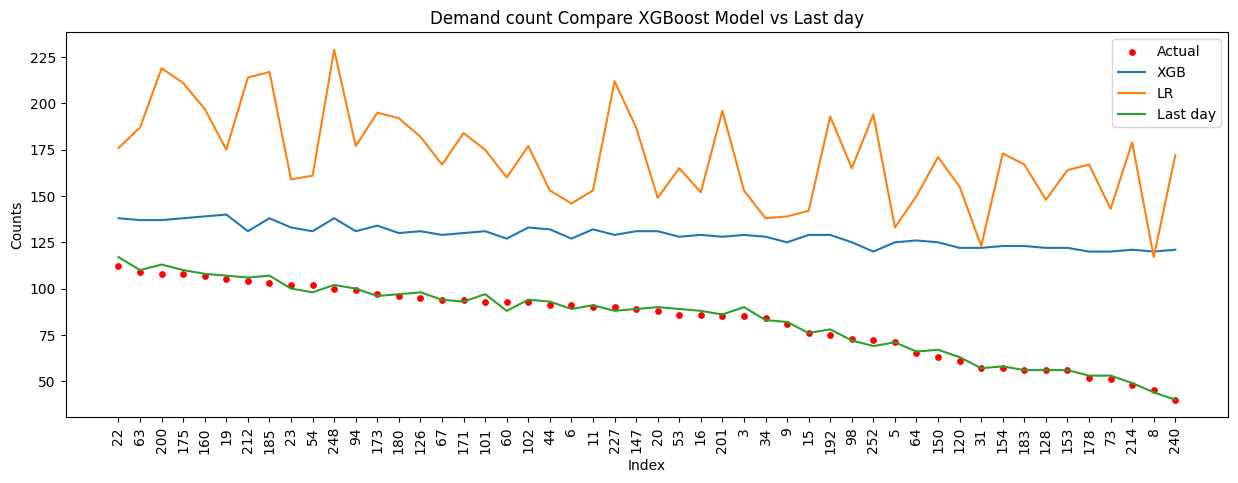

In [25]:
for i in range(0, 250, 50):
    if i == 0:
        compare_model_scatter(xgb_rides_df, lr_rides_df, i, i+50)
    else:
        compare_model_scatter(xgb_rides_df, lr_rides_df, i-15, i+35)